## Imports and Variables

In [1]:
import pandas
import numpy
import librosa
import requests
import seaborn
import sklearn
import matplotlib.pyplot as plt

from IPython.display import Image
from random import randrange
from sklearn import preprocessing
from sklearn.tree import export_graphviz
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from subprocess import call
from tqdm import tqdm

## Data Collection & Feature Extraction

In [2]:
# Get list of all recordings
data = requests.get("https://dolphin-app-9sdeq.ondigitalocean.app/api/v1/recordings").json()

recordings = []

for recording in data:
    recordings.append({
        "path": f'../recordings/combined/{recording["name"]}',
        "label": recording["label"],
        "environment": recording["environment"],
        "mfcc_mean": None,
        "mfcc_var": None,
        "n_samples": None,
        "chroma_mean": None,
        "chroma_var": None,
        "rms_mean": None,
        "rms_var": None,
        "sc_mean": None,
        "sc_var": None
    })

dataframe = pandas.json_normalize(recordings)

dataframe.head()

,path,label,environment,mfcc_mean,mfcc_var,n_samples,chroma_mean,chroma_var,rms_mean,rms_var,sc_mean,sc_var
0,../recordings/combined/a196dbae-1f50-4d0e-b345...,washing_hands,marsberg,None,None,None,None,None,None,None,None,None
1,../recordings/combined/826e36b1-2a7e-4d22-9c81...,washing_hands,marsberg,None,None,None,None,None,None,None,None,None
2,../recordings/combined/9a6b6b01-e466-47fb-9fcc...,washing_hands,marsberg,None,None,None,None,None,None,None,None,None
3,../recordings/combined/84ee02e6-44d5-4ab3-b875...,washing_hands,marsberg,None,None,None,None,None,None,None,None,None
4,../recordings/combined/ec24c55a-39ec-4b36-86fe...,washing_hands,marsberg,None,None,None,None,None,None,None,None,None


In [3]:
# Function to extract features
def preprocess(dataframe):
    for index, row in tqdm(dataframe.iterrows()):
        audio, sample_rate = librosa.load(row["path"])
        
        # Calculate mean and variance of the MFCCs
        mfcc_stft = librosa.feature.mfcc(y=audio, sr=sample_rate)
        dataframe.at[index, "mfcc_mean"] = numpy.mean(mfcc_stft)
        dataframe.at[index, "mfcc_var"] = numpy.var(mfcc_stft)
        
        # Calculate number of samples, representing length
        dataframe.at[index, "n_samples"] = audio.shape[0]

        # Calculate mean and variance of the chromagram
        chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        dataframe.at[index, "chroma_mean"] = numpy.mean(chroma_stft)
        dataframe.at[index, "chroma_var"] = numpy.var(chroma_stft)
        
        # Calculate mean and variance of the root mean square array
        rms = librosa.feature.rms(y=audio)
        dataframe.at[index, "rms_mean"] = numpy.mean(rms)
        dataframe.at[index, "rms_var"] = numpy.var(rms)
        
        # Calculate mean and variance of the spectral centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)
        dataframe.at[index, "sc_mean"] = numpy.mean(spectral_centroid)
        dataframe.at[index, "sc_var"] = numpy.var(spectral_centroid)
        
    return dataframe

In [4]:
dataframe = preprocess(dataframe)

119it [03:50,  1.94s/it]


In [5]:
# Extract separate dataframes for environments marsberg and duesseldorf
dataframe_marsberg = dataframe[dataframe["environment"] == "marsberg"]
dataframe_duesseldorf = dataframe[dataframe["environment"] == "duesseldorf"]

## Random Forest Classifier trained on data from _marsberg_

In [6]:
# Prepare and split data for training
y = dataframe_marsberg['label']
x = dataframe_marsberg.drop(['label', 'path', 'environment'], axis=1)

cols = x.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(x)
x = pandas.DataFrame(np_scaled, columns = cols)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

print(x_train.shape, x_test.shape)

(56, 9) (15, 9)


In [7]:
model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=0)

model.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

In [8]:
test_predictions = model.predict(x_test)
print(accuracy_score(y_test, test_predictions))

1.0


<AxesSubplot:xlabel='PREDICTED LABEL', ylabel='GROUND TRUTH'>

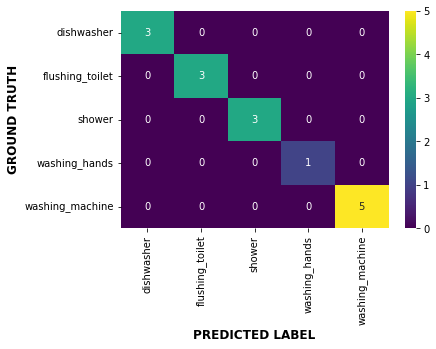

In [9]:
def confusion_matrix_table(y_true, y_pred):
    labels = sklearn.utils.multiclass.unique_labels(y_test)
    columns = [f'{label}' for label in labels]
    index = [f'{label}' for label in labels]
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=labels)
    table = pandas.DataFrame(confusion_matrix, columns=columns, index=index)
    return table

def confusion_matrix_plot(y_true, y_pred):
    table = confusion_matrix_table(y_true, y_pred)
    plot = seaborn.heatmap(table, annot=True, fmt="d", cmap="viridis")
    plt.yticks(rotation=0)
    plt.ylabel(
        'GROUND TRUTH', 
        fontsize = 12, 
        fontweight = 600
    )
    plt.xlabel(
        'PREDICTED LABEL', 
        fontsize = 12, 
        fontweight = 600
    )
    return plot

confusion_matrix_plot(y_test, test_predictions)

Estimator 3 / 10


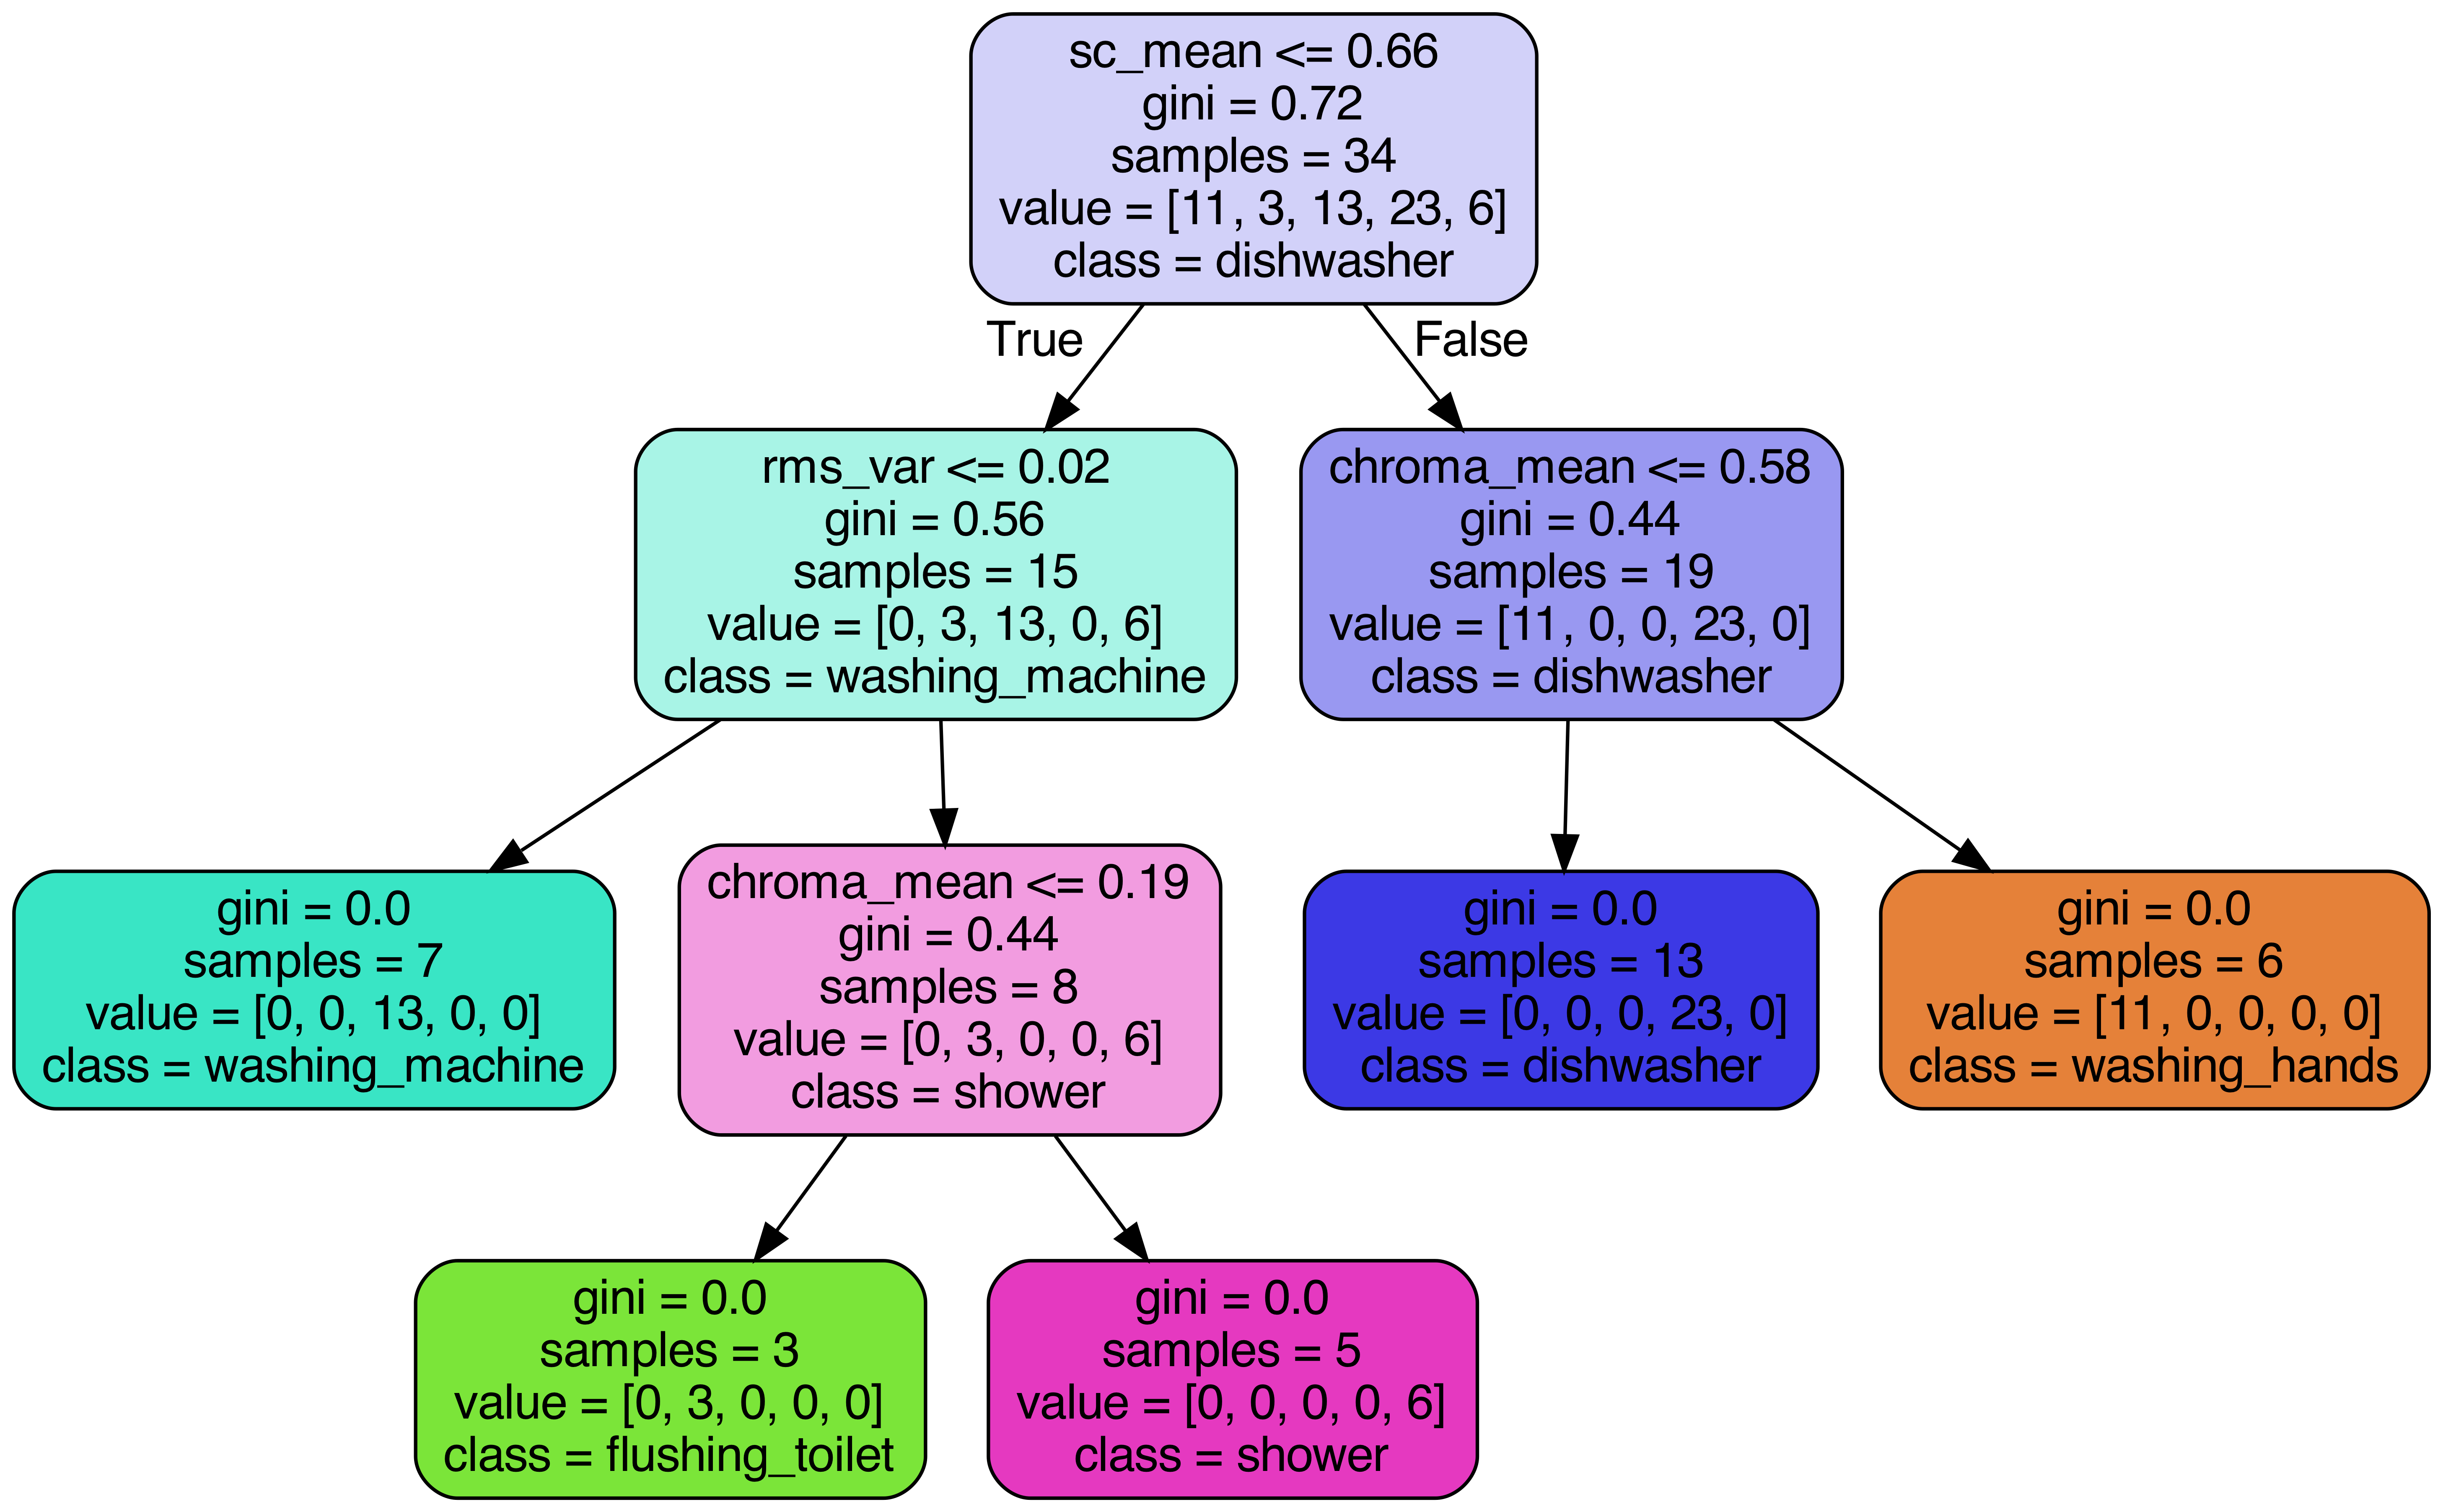

In [10]:
# Visualise a random estimator from the model
index = randrange(9)
export_graphviz(
    model.estimators_[index],
    out_file='files/tree.dot', 
    feature_names = x.columns,
    class_names = dataframe["label"].unique(),
    rounded = True,
    proportion = False, 
    precision = 2,
    filled = True
)
call(['dot', '-Tpng', 'files/tree.dot', '-o', 'files/tree.png', '-Gdpi=600'])
print(f'Estimator {index + 1} / 10')
Image(filename = 'files/tree.png')

In [11]:
# Calculate accuracy on data from duesseldorf
y_duesseldorf = dataframe_duesseldorf['label']
x_duesseldorf = dataframe_duesseldorf.drop(['label', 'path', 'environment'], axis=1)

cols = x_duesseldorf.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(x_duesseldorf)
x_duesseldorf = pandas.DataFrame(np_scaled, columns = cols)

test_duesseldorf_predictions = model.predict(x_duesseldorf)
print(accuracy_score(y_duesseldorf, test_duesseldorf_predictions))

0.3125


<AxesSubplot:xlabel='PREDICTED LABEL', ylabel='GROUND TRUTH'>

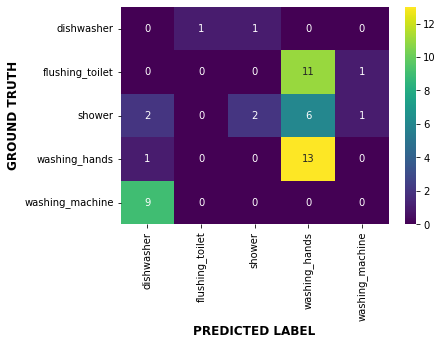

In [12]:
# Generate confusion matrix on data from duesseldorf
confusion_matrix_plot(y_duesseldorf, test_duesseldorf_predictions)

## Random Forest Classifier trained on data from all environments

In [13]:
# Prepare and split data for training
y_all = dataframe['label']
x_all = dataframe.drop(['label', 'path', 'environment'], axis=1)

cols = x_all.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(x_all)
x_all = pandas.DataFrame(np_scaled, columns = cols)

x_all_train, x_all_test, y_all_train, y_all_test = train_test_split(x_all, y_all, test_size=0.2, random_state=1)

print(x_all_train.shape, x_all_test.shape)

(95, 9) (24, 9)


In [14]:
model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=0)

model.fit(x_all_train, y_all_train)

RandomForestClassifier(random_state=0)

In [15]:
test_predictions = model.predict(x_all_test)
print(accuracy_score(y_all_test, test_predictions))

1.0


<AxesSubplot:xlabel='PREDICTED LABEL', ylabel='GROUND TRUTH'>

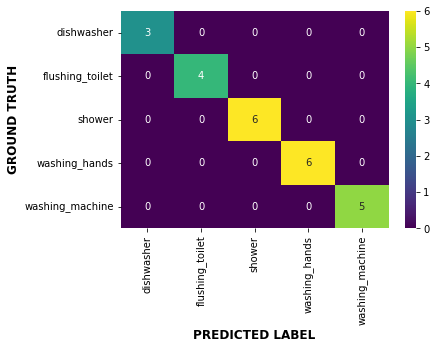

In [16]:
confusion_matrix_plot(y_all_test, test_predictions)

Estimator 4 / 10


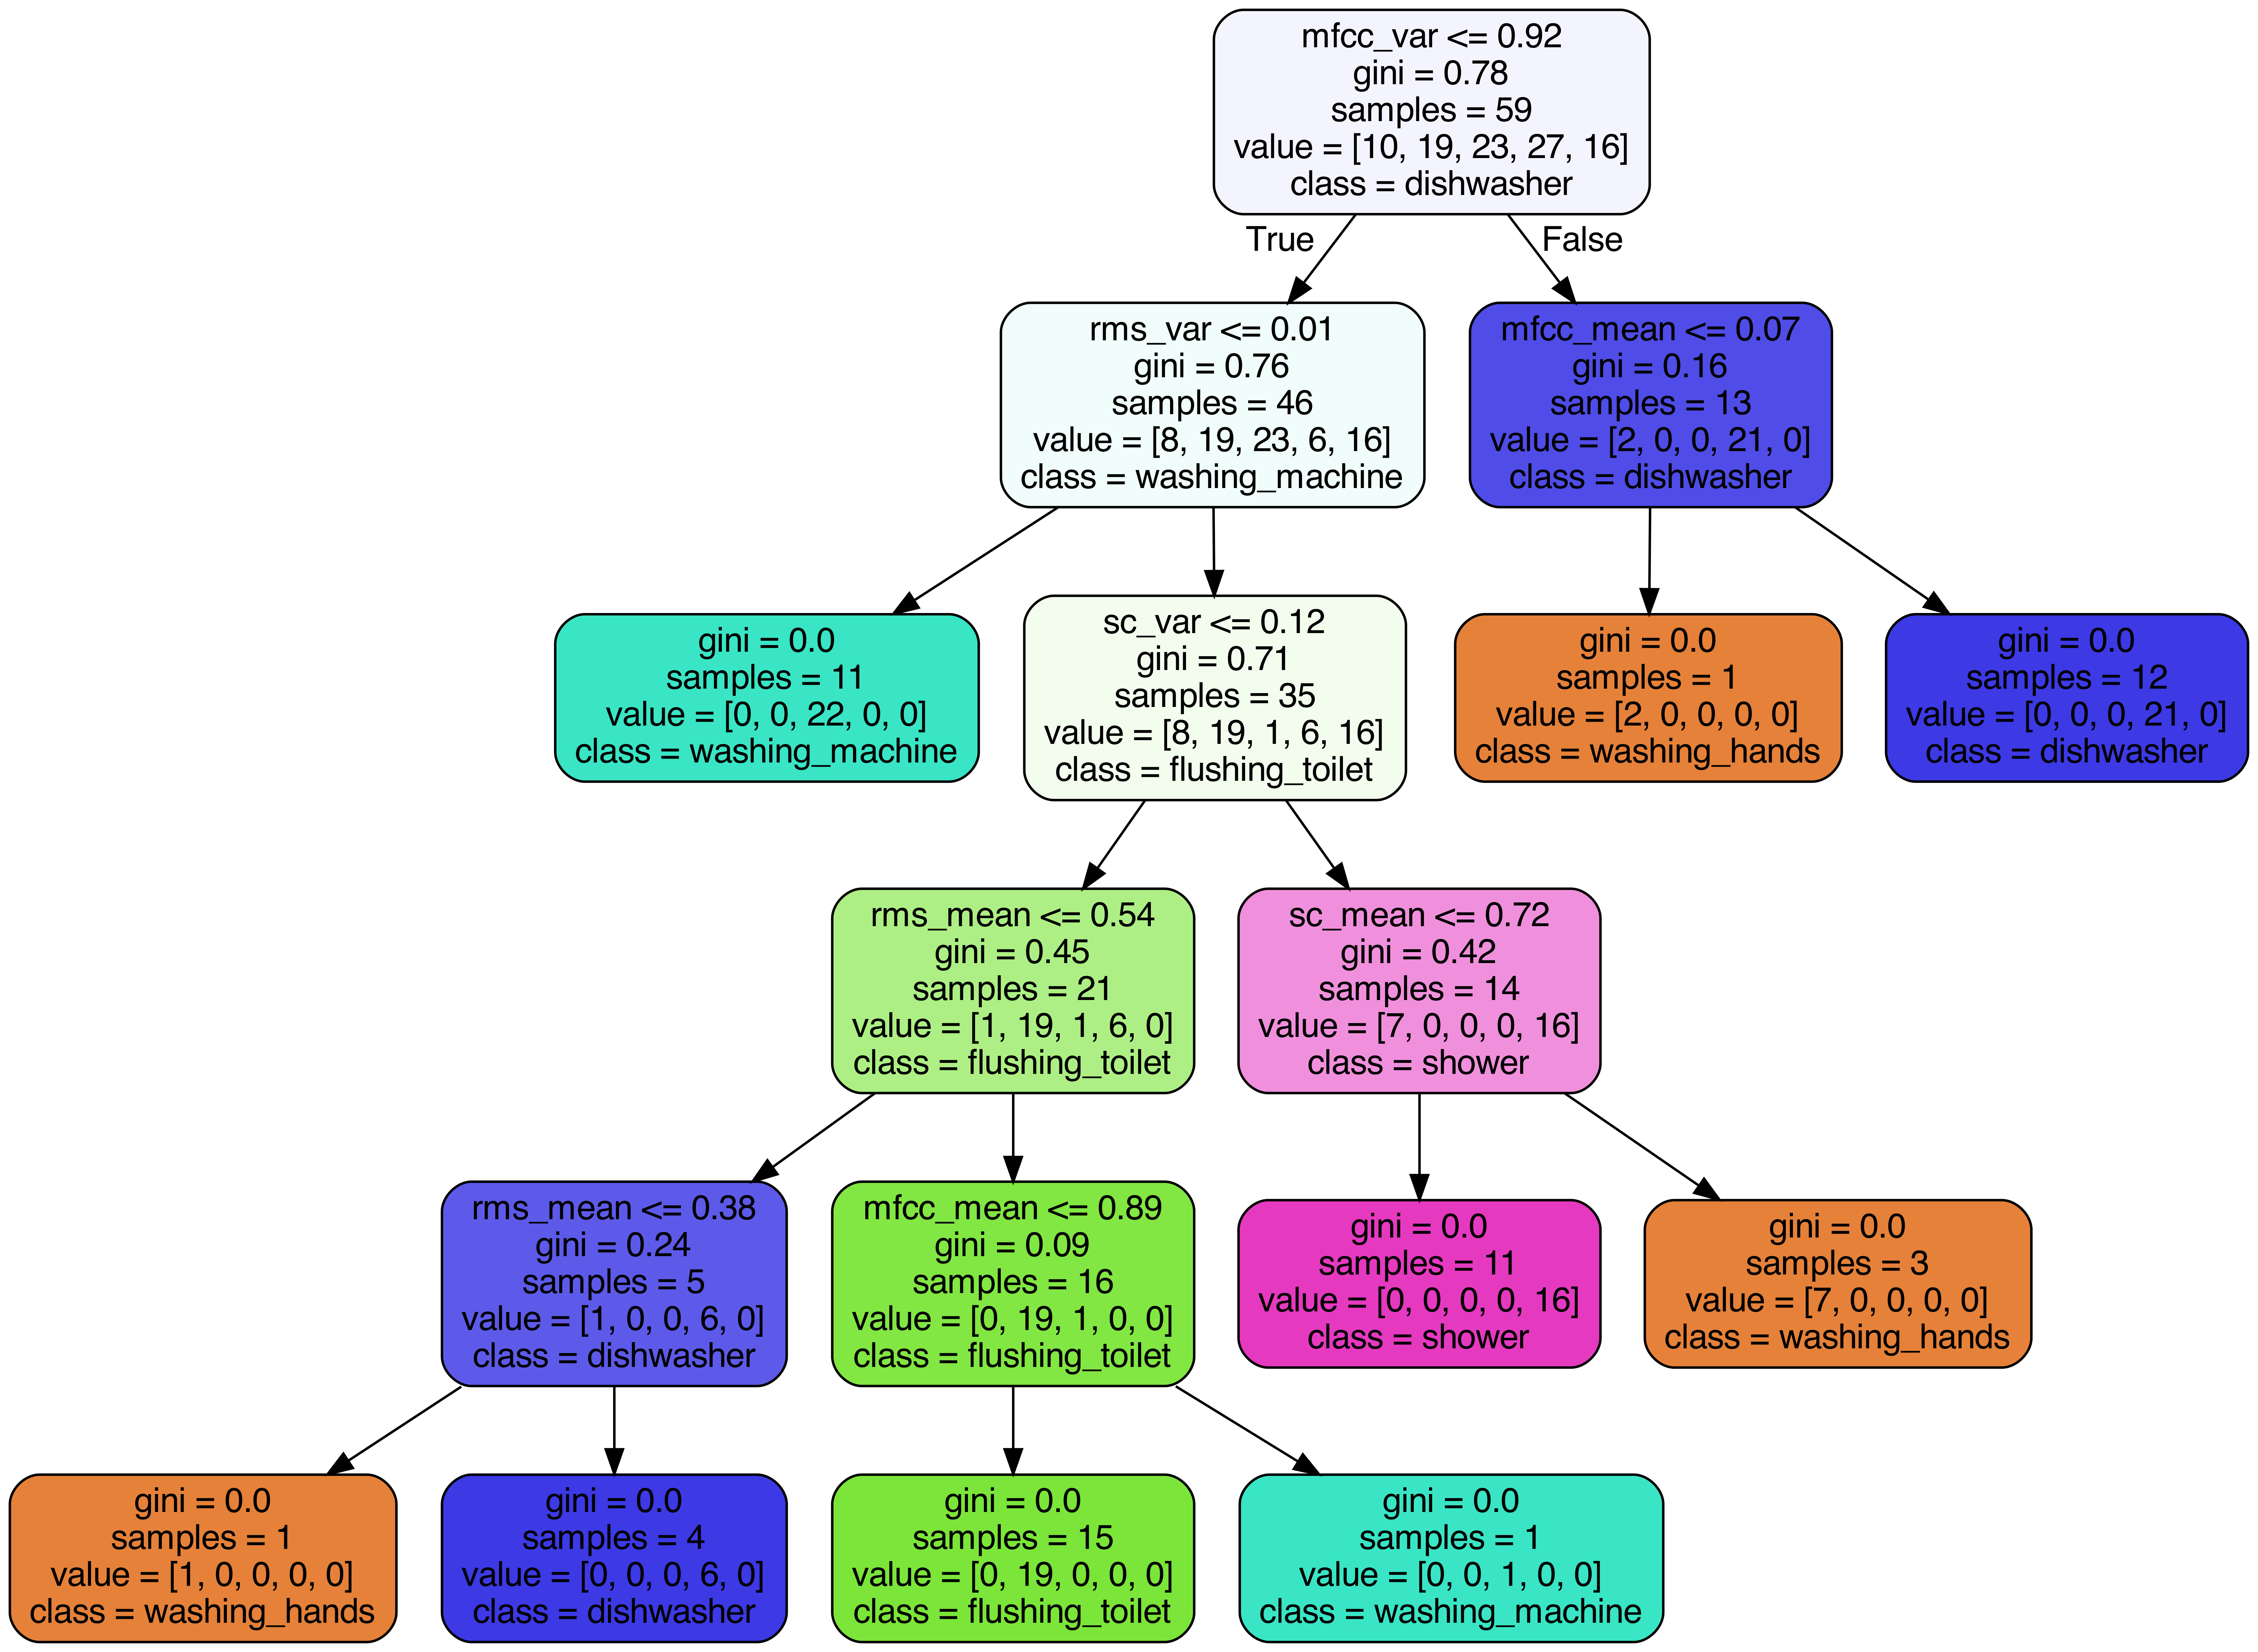

In [17]:
# Visualise a random estimator from the model
index = randrange(9)
export_graphviz(
    model.estimators_[index],
    out_file='files/tree.dot', 
    feature_names = x.columns,
    class_names = dataframe["label"].unique(),
    rounded = True,
    proportion = False, 
    precision = 2,
    filled = True
)
call(['dot', '-Tpng', 'files/tree.dot', '-o', 'files/tree.png', '-Gdpi=600'])
print(f'Estimator {index + 1} / 10')
Image(filename = 'files/tree.png')